# Connect colab to your google drive

In [1]:
# Connect to your google drive
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/ese_615/f110_yolo_2022

/content/drive/MyDrive/ese_615/f110_yolo_2022


In [ ]:
!unzip f110_dataset_20220209.zip

Archive:  f110_dataset_20220209.zip
replace f110_dataset_20220209/labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Useful tools:

In [3]:
import torch
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn

def DisplayImage(img):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    # image = np.transpose(image.copy(), (1, 2, 0))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()

def DisplayLabel(img, bboxs):
    # image = np.transpose(image.copy(), (1, 2, 0))
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    edgecolor = [1, 0, 0]
    if len(bboxs) == 1:
        bbox = bboxs[0]
        ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    elif len(bboxs) > 1:
        for bbox in bboxs:
            ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    ax.imshow(image)
    plt.show()


# Load data:

In [4]:
dataset_folder = '/content/drive/MyDrive/ese_615/f110_yolo_2022/f110_dataset_20220209/'
path = dataset_folder + "labels.npy"
labels = np.load(path)
print(len(labels))

1792


In [5]:
final_dim = [5, 10]
input_dim = [180, 320]
anchor_size = [(input_dim[0] / final_dim[0]), (input_dim[1] / final_dim[1])]
arr = np.arange(labels.shape[0])
np.random.shuffle(arr)

# convert feature map coord to image coord
def grid_cell(cell_indx, cell_indy):
    stride_0 = anchor_size[1]
    stride_1 = anchor_size[0]
    return np.array([cell_indx * stride_0, cell_indy * stride_1, cell_indx * stride_0 + stride_0, cell_indy * stride_1 + stride_1])

# convert from [c_x, c_y, w, h] to [x_l, y_l, x_r, y_r]
def bbox_convert(c_x, c_y, w, h):
    return [c_x - w/2, c_y - h/2, c_x + w/2, c_y + h/2]

# convert from [x_l, y_l, x_r, x_r] to [c_x, c_y, w, h]
def bbox_convert_r(x_l, y_l, x_r, y_r):
    return [x_l/2 + x_r/2, y_l/2 + y_r/2, x_r - x_l, y_r - y_l]

# calculating IoU
def IoU(a, b):
    # referring to IoU algorithm in slides
    inter_w = max(0, min(a[2], b[2]) - max(a[0], b[0]))
    inter_h = max(0, min(a[3], b[3]) - max(a[1], b[1]))
    inter_ab = inter_w * inter_h
    area_a = (a[3] - a[1]) * (a[2] - a[0])
    area_b = (b[3] - b[1]) * (b[2] - b[0])
    union_ab = area_a + area_b - inter_ab
    return inter_ab / union_ab

def assign_label(label):
    label_gt = np.zeros((5, final_dim[0], final_dim[1]))
    IoU_threshold = 0.01
    IoU_max = 0
    IoU_max_ind = [0, 0]

    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            label_assign = 0
            grid_info = grid_cell(ind_col, ind_row)
            label_bbox = bbox_convert(label[0], label[1], label[2], label[3])
            IoU_value = IoU(label_bbox, grid_info)
            if IoU_value > IoU_threshold:
                label_assign = 1
            if IoU_value > IoU_max:
                IoU_max = IoU_value
                IoU_max_ind[0] = ind_row
                IoU_max_ind[1] = ind_col

            # construct the gt vector
            if label_assign == 1:
                label_gt[0, ind_row, ind_col] = 1
                label_gt[1, ind_row, ind_col] = label[0] - (grid_info[0] + anchor_size[1]/2)
                label_gt[2, ind_row, ind_col] = label[1] - (grid_info[1] + anchor_size[0]/2)
                label_gt[3, ind_row, ind_col] = label[2] / float(input_dim[1])
                label_gt[4, ind_row, ind_col] = label[3] / float(input_dim[0])

    grid_info = grid_cell(IoU_max_ind[0], IoU_max_ind[1])
    label_gt[0, IoU_max_ind[0], IoU_max_ind[1]] = 1
    label_gt[1, IoU_max_ind[0], IoU_max_ind[1]] = label[0] - (grid_info[0] + anchor_size[1]/2)
    label_gt[2, IoU_max_ind[0], IoU_max_ind[1]] = label[1] - (grid_info[1] + anchor_size[0]/2)
    label_gt[3, IoU_max_ind[0], IoU_max_ind[1]] = label[2] / float(input_dim[1])
    label_gt[4, IoU_max_ind[0], IoU_max_ind[1]] = label[3] / float(input_dim[0])
    return label_gt

# Due to the small size of dataset, we preprocess them into memory to speed up training.
images = []
for ind in range(labels.shape[0]):
    img_path = dataset_folder + str(ind) + '.jpg'
    img = cv2.imread(img_path) / 255.0
    img = cv2.resize(img, (input_dim[1], input_dim[0]))
    images.append(img)
    print(ind)

# Construct datasets
class F110Dataset(torch.utils.data.Dataset):
    def __init__(self, scope, folder, labels):
        self.folder = folder
        self.labels = labels
        self.data_ind1 = (np.floor(self.labels.shape[0] / 10) * scope[0]).astype(int)
        self.data_ind2 = (np.floor(self.labels.shape[0] / 10) * scope[1]).astype(int)

    def __len__(self):
        return self.data_ind2 - self.data_ind1

    def __getitem__(self, index):
        label = self.labels[arr[index]].copy() / (360.0 / input_dim[0])
        label_gt = np.asarray(assign_label(label))
        img_np = images[arr[index]]
        img_np = np.transpose(img_np, (2, 0, 1))

        return torch.from_numpy(img_np).type('torch.FloatTensor'), \
                torch.from_numpy(label_gt).type('torch.FloatTensor'), label

train_set = F110Dataset([0, 9.5], dataset_folder, labels)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1, shuffle=True)
validation_set = F110Dataset([9.5, 10], dataset_folder, labels)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(3, 180, 320)
tensor([163.2500,  64.5000,  85.5000,  57.0000], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[163.2500,  64.5000,  85.5000,  57.0000]], dtype=torch.float64)


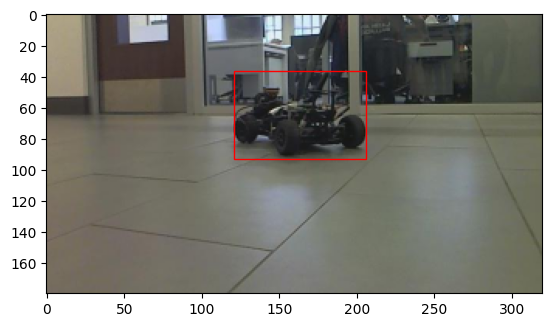

In [ ]:
## Plot one label to see if it's correct.

for data_ind, data_list in enumerate(train_loader):
    if data_ind == 0:
        image = data_list[0]
        label_gt = data_list[1]
        label = data_list[2]
        break
print(image[0].numpy().shape)
print(label[0])
print(label_gt[0][0])
print(label)
DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

In [ ]:
print(image.shape)
print(label.shape)
print(label_gt.shape)

# Model Definition

In [6]:
class F110_YOLO(torch.nn.Module):
    def __init__(self):
        super(F110_YOLO, self).__init__()
        # TODO: Change the channel depth of each layer
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm1 = nn.BatchNorm2d(10)
        self.relu1 = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(10, 20, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU(inplace = True)

        self.conv3 = nn.Conv2d(20, 30, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm3 = nn.BatchNorm2d(30)
        self.relu3 = nn.ReLU(inplace = True)

        self.conv4 = nn.Conv2d(30, 40, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm4 = nn.BatchNorm2d(40)
        self.relu4 = nn.ReLU(inplace = True)

        self.conv5 = nn.Conv2d(40, 50, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm5 = nn.BatchNorm2d(50)
        self.relu5 = nn.ReLU(inplace = True)

        self.conv6 = nn.Conv2d(50, 60, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm6 = nn.BatchNorm2d(60)
        self.relu6 = nn.ReLU(inplace = True)

        self.conv7 = nn.ConvTranspose2d(60, 50, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm7 = nn.BatchNorm2d(50)
        self.relu7 = nn.ReLU(inplace = True)

        self.conv8 = nn.ConvTranspose2d(50, 50, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm8 = nn.BatchNorm2d(50)
        self.relu8 = nn.ReLU(inplace = True)

        self.conv9 = nn.Conv2d(50, 5, kernel_size = 1, padding = 0, stride = 1)
        self.relu9 = nn.ReLU()

    def forward(self, x):
        debug = 0 # change this to 1 if you want to check network dimensions
        if debug == 1: print(0, x.shape)
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        if debug == 1: print(1, x.shape)
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        if debug == 1: print(2, x.shape)
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        if debug == 1: print(3, x.shape)
        x = torch.relu(self.batchnorm4(self.conv4(x)))
        if debug == 1: print(4, x.shape)
        x = torch.relu(self.batchnorm5(self.conv5(x)))
        if debug == 1: print(5, x.shape)
        x = torch.relu(self.batchnorm6(self.conv6(x)))
        if debug == 1: print(6, x.shape)
        x = torch.relu(self.batchnorm7(self.conv7(x)))
        if debug == 1: print(7, x.shape)
        x = torch.relu(self.batchnorm8(self.conv8(x)))
        if debug == 1: print(8, x.shape)
        x = self.conv9(x)
        if debug == 1: print(9, x.shape)
        x = torch.cat([x[:, 0:3, :, :], torch.sigmoid(x[:, 3:5, :, :])], dim=1)

        return x

    def get_loss(self, result, truth, lambda_coord = 5, lambda_noobj = 1):
        x_loss = (result[:, 1, :, :] - truth[:, 1, :, :]) ** 2
        y_loss = (result[:, 2, :, :] - truth[:, 2, :, :]) ** 2
        w_loss = (torch.sqrt(result[:, 3, :, :]) - torch.sqrt(truth[:, 3, :, :])) ** 2
        h_loss = (torch.sqrt(result[:, 4, :, :]) - torch.sqrt(truth[:, 4, :, :])) ** 2
        class_loss_obj = truth[:, 0, :, :] * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2
        class_loss_noobj = (1 - truth[:, 0, :, :]) * lambda_noobj * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2

        total_loss = torch.sum(lambda_coord * truth[:, 0, :, :] * (x_loss + y_loss + w_loss + h_loss) + class_loss_obj + class_loss_noobj)

        return total_loss


# Train your network

Save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [ ]:
## Begin training the model
train_loss_record = []
validation_loss_record = []
device = torch.device('cuda')
model = F110_YOLO().to(device)

In [ ]:
## Training Process
batch_size = 10 # TODO: What batchsize is good? 1? 10? 100?
epochs = 50 # TODO: How many times should we train? 1? 10? 100?
lr = 0.001 # TODO: What learning rate is good? 1? 0.1? 0.01?

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.to(device)
    model.train()
    train_loss = []
    validation_loss = []
    # ind = 0

    time_train = 0
    for image_t, label_t, _ in train_loader:
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        optimizer.zero_grad()

        result = model(image_t)
        loss = model.get_loss(result, label_t)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/batch_size)

    train_loss_record.append(np.average(train_loss))

    ## validationing
    model.eval()
    object_in_class = 0
    truth_in_class = 0
    for image_t, label_t, _ in validation_loader:
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        result = model(image_t)
        loss = model.get_loss(result, label_t)
        validation_loss.append(loss.item())

    validation_loss_record.append(np.average(validation_loss))
    print("total epoch:", len(train_loss_record), '| train_loss:', np.average(train_loss), '| validation_loss:', np.average(validation_loss), )

# save the model
model_save_name = 'model_{}.pt'.format(len(train_loss_record))
path = "" + model_save_name
torch.save(model.state_dict(), path)

from tempfile import TemporaryFile
path = "loss_{}.npy".format(len(train_loss_record))
outfile = TemporaryFile()
np.save(path, [np.array(train_loss_record), np.array(validation_loss_record)])

total epoch: 1 | train_loss: 193872.76084558823 | validation_loss: 145113.01142578124
total epoch: 2 | train_loss: 99648.85150735296 | validation_loss: 119255.21206597223
total epoch: 3 | train_loss: 47086.745919117646 | validation_loss: 26342.39995388455
total epoch: 4 | train_loss: 27170.20611902573 | validation_loss: 13917.12540757921
total epoch: 5 | train_loss: 18922.296916360294 | validation_loss: 15927.11441514757
total epoch: 6 | train_loss: 13432.823134191176 | validation_loss: 9313.688744269477
total epoch: 7 | train_loss: 9822.528803998164 | validation_loss: 5543.583187442356
total epoch: 8 | train_loss: 8042.094674862133 | validation_loss: 6728.291384887695
total epoch: 9 | train_loss: 6107.817196691178 | validation_loss: 2897.7601435343427
total epoch: 10 | train_loss: 4127.592150735295 | validation_loss: 4252.377038913303
total epoch: 11 | train_loss: 3739.4513321461404 | validation_loss: 3134.4107262505427
total epoch: 12 | train_loss: 3092.5588496668197 | validation_los

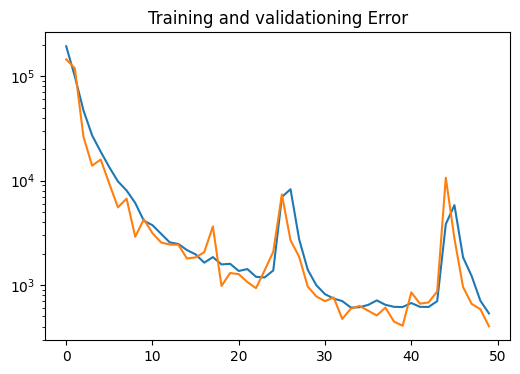

[402.1231875949436]
[534.067425178079]


In [ ]:
## Plot loss curves

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(train_loss_record)), train_loss_record, range(len(validation_loss_record)), validation_loss_record)
ax.set_yscale('log')
ax.set_title('Training and validationing Error')
plt.show()
print(validation_loss_record[-1:])
print(train_loss_record[-1:])

In [ ]:
## Converting label to bounding boxes

def label_to_box_xyxy(result, threshold = 0.9):
    validation_result = []
    result_prob = []
    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            grid_info = grid_cell(ind_col, ind_row)
            validation_result_cell = []
            if result[0, ind_row, ind_col] >= threshold:
                c_x = grid_info[0] + anchor_size[1]/2 + result[1, ind_row, ind_col]
                c_y = grid_info[1] + anchor_size[0]/2 + result[2, ind_row, ind_col]
                w = result[3, ind_row, ind_col] * input_dim[1]
                h = result[4, ind_row, ind_col] * input_dim[0]
                x1, y1, x2, y2 = bbox_convert(c_x, c_y, w, h)
                x1 = np.clip(x1, 0, input_dim[1])
                x2 = np.clip(x2, 0, input_dim[1])
                y1 = np.clip(y1, 0, input_dim[0])
                y2 = np.clip(y2, 0, input_dim[0])
                validation_result_cell.append(x1)
                validation_result_cell.append(y1)
                validation_result_cell.append(x2)
                validation_result_cell.append(y2)
                result_prob.append(result[0, ind_row, ind_col])
                validation_result.append(validation_result_cell)
    validation_result = np.array(validation_result)
    result_prob = np.array(result_prob)
    return validation_result, result_prob


def voting_suppression(result_box, iou_threshold = 0.5):
    votes = np.zeros(result_box.shape[0])
    for ind, box in enumerate(result_box):
        for box_validation in result_box:
            if IoU(box_validation, box) > iou_threshold:
                votes[ind] += 1
    return (-votes).argsort()


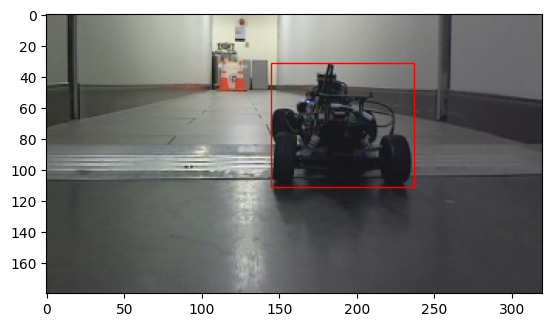

<ipython-input-7-25bf5b65e460>:30: RuntimeWarning: invalid value encountered in scalar divide
  return inter_ab / union_ab


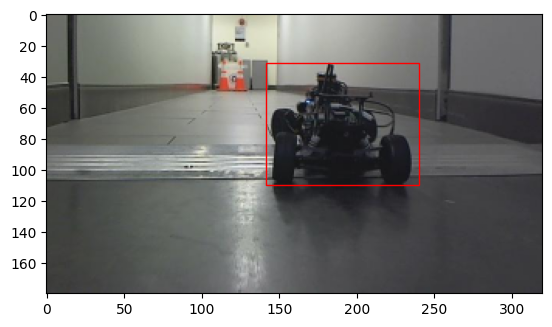

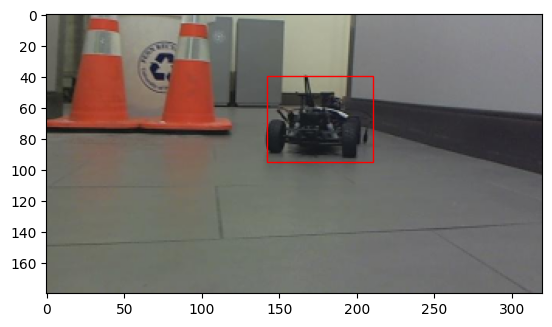

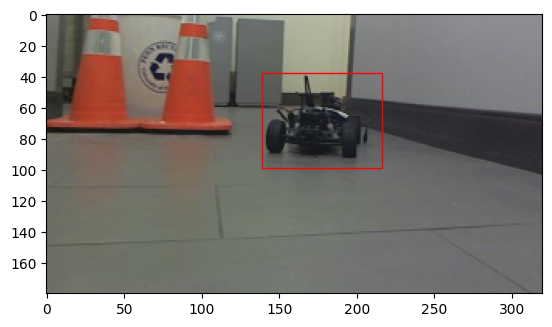

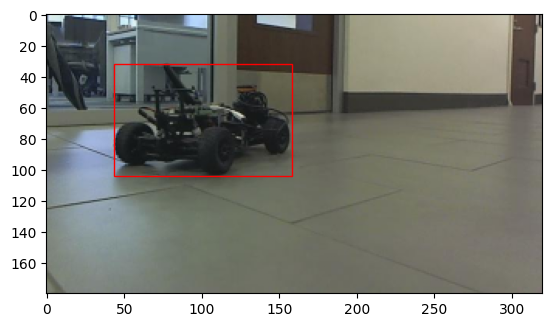

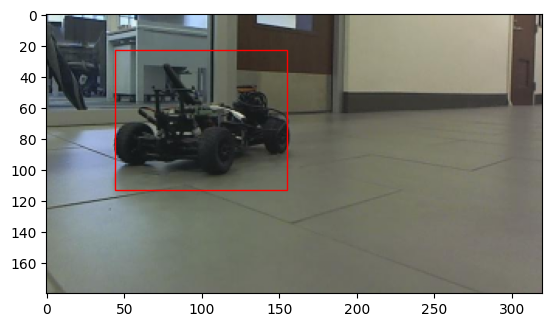

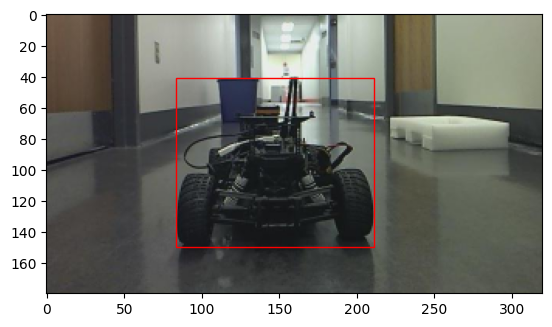

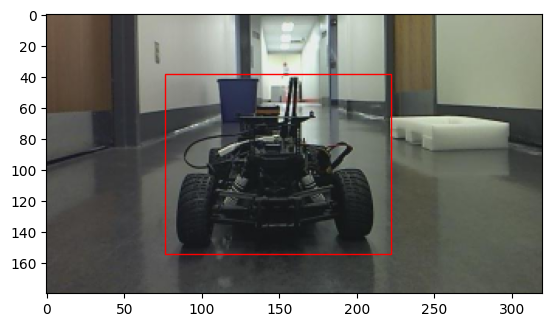

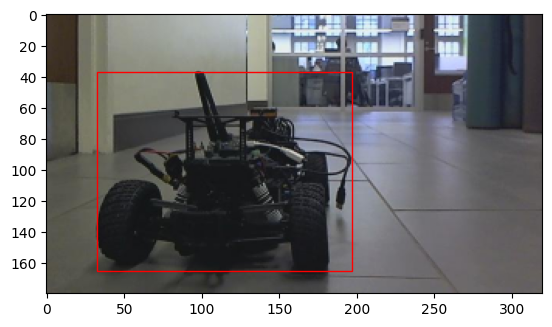

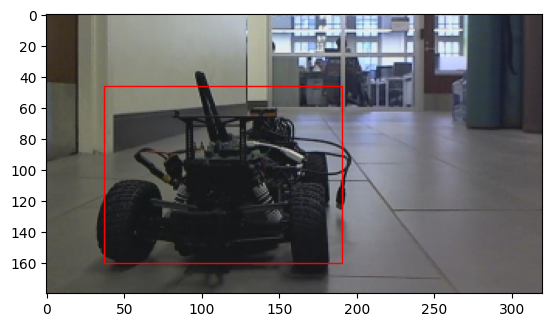

In [ ]:
## Display some images in the validation set

# validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=False)
for data_ind, data_list in enumerate(validation_loader):
    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]
    if data_ind == 5:
        break

    # display groud truth
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

    # display detection
    voting_iou_threshold = 0.5
    confi_threshold = 0.4

    image_t = image.to(device)
    label_gt_t = label_gt.to(device)
    result = model(image_t)
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), bboxs_2)


In [ ]:
## Calculate accuracy

model.eval()
object_in_class = 0
truth_in_class = 0
voting_iou_threshold = 0.5
confi_threshold = 0.5

for data_ind, data_list in enumerate(validation_loader):
    # print(data_ind)

    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]

    result = model(image.to(device))
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    # prob = result_prob[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])

    pos_change = np.sqrt((label[0][0] - c_x) ** 2 + (label[0][1] - c_y) ** 2)
    x_l, y_l, x_r, y_r = bbox_convert(label[0][0], label[0][1], label[0][2], label[0][3])
    label_xxyy = [x_l, y_l, x_r, y_r]
    # print(label[0])
    # print(bboxs_2[0])
    # print(pos_change)
    if pos_change < 20 and IoU(bbox, label_xxyy) > 0.5:
        object_in_class += 1
    truth_in_class += 1

accuracy = object_in_class / truth_in_class

print('accuracy', accuracy)


<ipython-input-7-25bf5b65e460>:30: RuntimeWarning: invalid value encountered in scalar divide
  return inter_ab / union_ab


accuracy 0.8444444444444444


### Tensorrt portion


In [7]:
## load the model
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = F110_YOLO()
model_save_name = 'model_50.pt'
path = F"/content/drive/MyDrive/ese_615/f110_yolo_2022/{model_save_name}"
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model = model.to(device)

path = F"/content/drive/MyDrive/ese_615/f110_yolo_2022/loss_50.npy"
loss = np.load(path, allow_pickle=True)

In [8]:

!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.8 MB/s eta 0:00:00


In [9]:

import onnx
validation_set = F110Dataset([9.5, 10], dataset_folder, labels)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=True)

for image_t, label_t, _ in validation_loader:
    image_t = image_t.to(device)

torch.onnx.export(model,             # model being run
                  image_t,           # model input (or a tuple for multiple inputs)
                  "yolof110.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True)

In [10]:
# Download ONNX to TensorRT converter
%cd ../
!git clone https://github.com/Linaom1214/tensorrt-python.git
%cd tensorrt-python
!ls
# Export TensorRT-engine model
!python export.py -o /content/drive/MyDrive/ese_615/yolof110.onnx -e ./yolof110.trt -p fp16

/content/drive/MyDrive/ese_615
fatal: destination path 'tensorrt-python' already exists and is not an empty directory.
/content/drive/MyDrive/ese_615/tensorrt-python
cpp  export.py	image_batch.py	README_CN.md  README.md  src  trt.py  utils  yolof110.onnx
Traceback (most recent call last):
  File "/content/drive/MyDrive/ese_615/tensorrt-python/export.py", line 7, in <module>
    import tensorrt as trt
ModuleNotFoundError: No module named 'tensorrt'


In [11]:
!pip install tensorrt
!pip install pycuda

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=41add49e2404fc7002098d5745846aacc5e43fd43063fb1f0e5ac671d5712330
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=2d1f07bbc202f1af1d423a20cc0e14ff09bc4d41d6680c1616458a3c5ac096d3
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully 

In [12]:
from copy import deepcopy
from pathlib import Path
import time
from typing import Tuple
from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda
import torch



<ipython-input-20-442ac6688b83>:3: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):  # we expect only one input
<ipython-input-20-442ac6688b83>:4: DeprecationWarning: Use get_tensor_shape instead.
  input_shape = engine.get_binding_shape(binding)
<ipython-input-20-442ac6688b83>:5: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  input_size = trt.volume(input_shape) * engine.max_batch_size * np.dtype(np.float32).itemsize  # in bytes
<ipython-input-20-442ac6688b83>:10: DeprecationWarning: Use get_tensor_shape instead.
  output_shape = engine.get_binding_shape(binding)
<ipython-input-20-442ac6688b83>:12: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  host_output = cuda.pagelocked_empty(trt.volume(output_shape) * engine.max_batch_size, dtype=np.float32)
<ipython-input-20-442ac6688b83>:171: DeprecationWarning: Use execute_async_v2 inste

Running inference on /content/drive/MyDrive/ese_615/f110_yolo_2022/f110_dataset_20220209/50.jpg
Inference performed in 3.29ms.
Result vector has shape: torch.Size([250])
Reshaped output vector shape: torch.Size([1, 5, 5, 10])
One bounding box found at [107.48167419  81.13420868  75.74331665  32.83500671]


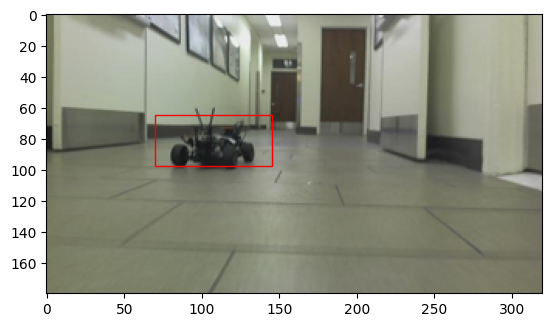

Confidence: 96.70%


In [20]:
def allocate_buffers(engine):
    for binding in engine:
        if engine.binding_is_input(binding):  # we expect only one input
            input_shape = engine.get_binding_shape(binding)
            input_size = trt.volume(input_shape) * engine.max_batch_size * np.dtype(np.float32).itemsize  # in bytes
            input_dtype = trt.nptype(engine.get_tensor_dtype(binding))
            host_input = cuda.pagelocked_empty(input_size, input_dtype)
            device_input = cuda.mem_alloc(input_size)
        else:  # and one output
            output_shape = engine.get_binding_shape(binding)
            # create page-locked memory buffers (i.e. won't be swapped to disk)
            host_output = cuda.pagelocked_empty(trt.volume(output_shape) * engine.max_batch_size, dtype=np.float32)
            device_output = cuda.mem_alloc(host_output.nbytes)
    return host_input, device_input, host_output, device_output

def DisplayLabel(image, bboxs):
    # image = np.transpose(image.copy(), (1, 2, 0))
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    # image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    edgecolor = [1, 0, 0]
    if len(bboxs) == 1:
        bbox = bboxs[0]
        ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
        print(f"One bounding box found at {bbox}")
    elif len(bboxs) > 1:
        for bbox in bboxs:
            ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    # print(f"Bounding boxes predicted: {bboxs}")
    ax.imshow(image)
    plt.savefig("detection_output.png")
    plt.show()

# convert from [c_x, c_y, w, h] to [x_l, y_l, x_r, y_r]
def bbox_convert(c_x, c_y, w, h):
    return [c_x - w/2, c_y - h/2, c_x + w/2, c_y + h/2]

# convert from [x_l, y_l, x_r, x_r] to [c_x, c_y, w, h]
def bbox_convert_r(x_l, y_l, x_r, y_r):
    return [x_l/2 + x_r/2, y_l/2 + y_r/2, x_r - x_l, y_r - y_l]

# calculating IoU
def IoU(a, b):
    # referring to IoU algorithm in slides
    inter_w = max(0, min(a[2], b[2]) - max(a[0], b[0]))
    inter_h = max(0, min(a[3], b[3]) - max(a[1], b[1]))
    inter_ab = inter_w * inter_h
    area_a = (a[3] - a[1]) * (a[2] - a[0])
    area_b = (b[3] - b[1]) * (b[2] - b[0])
    union_ab = area_a + area_b - inter_ab
    if union_ab == 0:
        return 0
    return inter_ab / union_ab

def grid_cell(cell_indx, cell_indy, anchor_size):
    stride_0 = anchor_size[1]
    stride_1 = anchor_size[0]
    return np.array([cell_indx * stride_0, cell_indy * stride_1, cell_indx * stride_0 + stride_0, cell_indy * stride_1 + stride_1])

def label_to_box_xyxy(result: torch.Tensor,
                      input_shape: Tuple,
                      output_shape: Tuple,
                      anchor_size: tuple,
                      threshold = 0.9):
    validation_result = []
    result_prob = []
    for ind_row in range(output_shape[2]):
        for ind_col in range(output_shape[3]):
            grid_info = grid_cell(ind_col, ind_row, anchor_size)
            validation_result_cell = []
            if result[0, ind_row, ind_col] >= threshold:
                c_x = grid_info[0] + anchor_size[1]/2 + result[1, ind_row, ind_col]
                c_y = grid_info[1] + anchor_size[0]/2 + result[2, ind_row, ind_col]
                w = result[3, ind_row, ind_col] * input_shape[2]
                h = result[4, ind_row, ind_col] * input_shape[3]
                x1, y1, x2, y2 = bbox_convert(c_x, c_y, w, h)
                x1 = np.clip(x1, 0, input_shape[3])
                x2 = np.clip(x2, 0, input_shape[3])
                y1 = np.clip(y1, 0, input_shape[2])
                y2 = np.clip(y2, 0, input_shape[2])
                validation_result_cell.append(x1)
                validation_result_cell.append(y1)
                validation_result_cell.append(x2)
                validation_result_cell.append(y2)
                result_prob.append(result[0, ind_row, ind_col])
                validation_result.append(validation_result_cell)
    validation_result = np.array(validation_result)
    result_prob = np.array(result_prob)
    return validation_result, result_prob

def voting_suppression(result_box, iou_threshold = 0.5):
    votes = np.zeros(result_box.shape[0])
    for ind, box in enumerate(result_box):
        for box_validation in result_box:
            if IoU(box_validation, box) > iou_threshold:
                votes[ind] += 1
    return (-votes).argsort()

def main():

    # 1. PREPROCESSING
    trt_model_path = Path(r"/content/drive/MyDrive/ese_615/f110_yolo_2022/yolof110.trt")
    test_image_path = Path(r"/content/drive/MyDrive/ese_615/f110_yolo_2022/f110_dataset_20220209/50.jpg")
    # Expected output shape.

    output_shape = (1,5,5,10)

    # Model input shape (b, c, h, w)
    model_input_shape = (1, 3, 180, 320)

    # Compute the size of the anchor boxes.
    anchor_size = [(model_input_shape[2] / output_shape[2]), (model_input_shape[3] / output_shape[3])]
    # Take the model input shape and convert it to the format Pillow accepts
    # (Width, Height). We can tell Pillow to resize
    resize_shape_wh = (model_input_shape[3], model_input_shape[2])
    test_image = Image.open(test_image_path)
    raw_image_shape = test_image.size
    test_image = test_image.resize(resize_shape_wh, resample=Image.Resampling.BICUBIC)
    test_image = np.array(test_image, dtype=np.float32, order="C")
    # Normalize the test image.
    test_image = test_image / 255.0

    # Image should be in H,W,C
    numpy_image = deepcopy(test_image)
    # cv.imwrite("temp_img.png", numpy_image)

    # Reshape the np array that used to be a PIL image into "CHW" (PyTorch shape
    # convention).
    test_image = np.transpose(test_image, [2, 0, 1])
    # CHW to NCHW format. I.e., adding another dimension in case you had a batch
    # size greater than 1.
    test_image = np.expand_dims(test_image, axis=0)
    # Convert the image to row major order in memory.
    test_image = np.array(test_image, dtype=np.float32, order="C")


    # 2. INFERENCE
    # Set up runtime and deserialize the engine file (the TensorRT model
    f = open(trt_model_path, "rb")
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))

    f1yolo_engine = runtime.deserialize_cuda_engine(f.read())
    context = f1yolo_engine.create_execution_context()

    # Allocate memory for input and output.
    host_input, device_input, host_output, device_output = allocate_buffers(engine=f1yolo_engine)
    # host_input is a region of page_locked memory on the host, while
    # device_input is a memory location allocated on the GPU. Likewise,
    # host_output is a region of page_locked memory on the host, and
    # device_output is the memory region on the device that is allocated to
    # store the output of the engine.

    # Also, we create what's called a CUDA stream object. A CUDA stream is kind
    # of like an OS thread--it's an independent sequence of (CUDA) instructions.
    # For our case, we only need one stream, as we only want the capability to
    # process a single image at a time. BUT, you could create multiple, parallel
    # streams to process multiple images asynchronously if you needed to. To add
    # instructions to this stream, we can specify this stream as an argument to
    # each of the CUDA operations that we specify below.
    inference_stream = cuda.Stream()

    # Pass image through model.
    print(f"Running inference on {test_image_path}")
    # Copy the input image into the host_input page_locked memory.
    host_input = test_image
    # Copy the image data in the hosts memory to the device's memory.
    inference_start = time.perf_counter()
    cuda.memcpy_htod_async(device_input, host_input, inference_stream)
    # Run inference. This essentially tells teh CPU to take the input and pass
    # it through the engine, place the result in the output location.
    context.execute_async(bindings=[int(device_input), int(device_output)],
                          stream_handle=inference_stream.handle)
    # Copy the results from GPU memory back to the host.
    cuda.memcpy_dtoh_async(host_output, device_output, inference_stream)
    inference_stream.synchronize()
    inference_end = time.perf_counter()
    print(f"Inference performed in {(inference_end - inference_start)*1000:.2f}ms.")

    # The output tensors will be flat arrays out of the engine, so need to
    # reshape these to the expected output format to make sense of them.
    result_tensor = torch.Tensor(host_output)
    print(f"Result vector has shape: {result_tensor.shape}")
    # Reshape result tensor.
    result_tensor = result_tensor.reshape(output_shape)
    print(f"Reshaped output vector shape: {result_tensor.shape}")

    # 3. POST PROCESSING.
    # Now, begin the "post processing." For this, we basically want to run NMS
    # on the predicted output bounding boxes (each of the 6x10==60 5-element
    # predicted bboxes) and return those bounding boxes above the specified
    # confidence threshold.

    # Then, as a debugging step, can draw those bounding boxes on the image.

    # UPDATE: The notebook already provides functions for working with this
    # particular model's outputs. So, once we reshape above, we should be able
    # to use the existing functions to get things into the proper form.

    # display detection
    voting_iou_threshold = 0.5
    confi_threshold = 0.4

    # result = model(image_t)
    # result = result.detach().cpu().numpy()
    # NOTE Need to know what the output dimensions are. I.e., what shape is
    # result here?
    bboxes, result_prob = label_to_box_xyxy(result=result_tensor[0],
                                           input_shape=model_input_shape,
                                           output_shape=output_shape,
                                           anchor_size=anchor_size)
    vote_rank = voting_suppression(bboxes, voting_iou_threshold)
    bbox = bboxes[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, h, w]])
    # DisplayLabel(np.transpose(test_image[0], (1, 2, 0)), bboxs_2)
    DisplayLabel(image=numpy_image, bboxs=bboxs_2)
    print(f"Confidence: {result_prob[vote_rank[0]]*100:.2f}%")


if __name__ == "__main__":

    main()

